In [527]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, balanced_accuracy_score,
                             precision_score, recall_score, f1_score, roc_curve, roc_auc_score,
                             precision_recall_curve, brier_score_loss, classification_report)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from scipy.stats import pointbiserialr

- *Number of Stocks:* The dataset contains data for 200 stocks (rows).
- *Financial Metrics:* There are 20 features (columns) named "metric_0" to "metric_19". Each metric is generated using a standard normal distribution.
- *Target Variable:*
    - A weighted sum of the 20 metrics is calculated for each stock using random weights.
    - Gaussian noise is added to the sum.
    - The median value of the resulting scores is computed.
    - Stocks with a score above the median are labeled as 1 (indicating a positive outcome), and those below are labeled as 0 (negative outcome).

In [528]:
def create_dataset(num_stocks=200, num_matrics=20, seed=42, base_corr=0.3, high_corr=0.8):
    np.random.seed(seed)
    # Create a covariance matrix with a base correlation off-diagonally
    cov = np.full((num_matrics, num_matrics), base_corr)
    np.fill_diagonal(cov, 1)  # Diagonal variances are 1
    
    # Introduce high correlation among selected features (metric_7, metric_8, metric_9, metric_10)
    indices = [7, 8, 9, 10]
    for i in indices:
        for j in indices:
            if i != j:
                cov[i, j] = high_corr
                
    mean = np.zeros(num_matrics)
    
    # Generate synthetic financial metrics with correlation using a multivariate normal distribution
    X = np.random.multivariate_normal(mean, cov, size=num_stocks)
    columns = [f"metric_{i}" for i in range(num_matrics)]
    df = pd.DataFrame(X, columns=columns)
    
    # Generating the binary target based on a weighted sum of features with noise
    weights = np.random.rand(num_matrics)
    score = np.dot(X, weights) + np.random.normal(0, 0.1, num_stocks)
    threshold = np.median(score)
    target = (score > threshold).astype(int)
    df["Target"] = target
    return df

# Create the dataset and display the first few rows
df = create_dataset()
print(df.head())

def create_dataset(num_stocks=200, num_matrics=20, seed=42, base_corr=0.3, high_corr=0.8):
    np.random.seed(seed)
    # Create a covariance matrix with a base correlation off-diagonally
    cov = np.full((num_matrics, num_matrics), base_corr)
    np.fill_diagonal(cov, 1)  # Diagonal variances are 1
    
    # Introduce high correlation among selected features (metric_7, metric_8, metric_9, metric_10)
    indices = [7, 8, 9, 10]
    for i in indices:
        for j in indices:
            if i != j:
                cov[i, j] = high_corr
                
    mean = np.zeros(num_matrics)
    
    # Generate synthetic financial metrics with correlation using a multivariate normal distribution
    X = np.random.multivariate_normal(mean, cov, size=num_stocks)
    columns = [f"metric_{i}" for i in range(num_matrics)]
    df = pd.DataFrame(X, columns=columns)
    
    # Generating the binary target based on a weighted sum of features with noise
    weights = np.random.rand(num_matrics)
    score = np.dot(X, weights) + np.random.normal(0, 0.1, num_stocks)
    threshold = np.median(score)
    target = (score > threshold).astype(int)
    df["Target"] = target
    return df

# Create the dataset and display the first few rows
df = create_dataset()
print(df.head())

   metric_0  metric_1  metric_2  metric_3  metric_4  metric_5  metric_6  \
0  1.535717 -0.476388  0.836957  0.546451 -0.372656 -0.996765 -0.336259   
1 -0.297030  0.751612  2.107180  0.889420  0.226726  1.111718  2.155254   
2  0.135167  0.374047  0.438984  0.918495  0.108973  0.380449  0.215487   
3 -1.201235 -0.565177  1.000590 -0.491416  0.587458  0.334157 -2.434316   
4 -0.608164 -0.220959  0.311845  0.559114 -0.878816 -0.120783 -0.216767   

   metric_7  metric_8  metric_9  ...  metric_11  metric_12  metric_13  \
0  0.198250 -0.239772  0.344041  ...   1.311565   1.917398   0.019085   
1  1.828384  0.546081  0.517837  ...   0.465156   0.452487   0.806080   
2  0.782829  0.891028  0.607093  ...  -0.499752   0.778728   0.156708   
3 -0.640490 -0.667100 -0.823550  ...   0.516801  -1.557965  -0.752961   
4 -0.066923  0.005244  0.097794  ...   0.383102  -0.143074   0.173901   

   metric_14  metric_15  metric_16  metric_17  metric_18  metric_19  Target  
0   0.682541   0.299307  -0.1375

In [529]:
# Create a dataset with 200 stocks and 20 metrics 
df = create_dataset()
df.head()

,metric_0,metric_1,metric_2,metric_3,metric_4,metric_5,metric_6,metric_7,metric_8,metric_9,...,metric_11,metric_12,metric_13,metric_14,metric_15,metric_16,metric_17,metric_18,metric_19,Target
0,1.535717,-0.476388,0.836957,0.546451,-0.372656,-0.996765,-0.336259,0.198250,-0.239772,0.344041,...,1.311565,1.917398,0.019085,0.682541,0.299307,-0.137597,-0.752332,0.025191,0.728539,1
1,-0.297030,0.751612,2.107180,0.889420,0.226726,1.111718,2.155254,1.828384,0.546081,0.517837,...,0.465156,0.452487,0.806080,1.202980,0.348454,1.204719,1.093647,-0.376846,1.572815,1
2,0.135167,0.374047,0.438984,0.918495,0.108973,0.380449,0.215487,0.782829,0.891028,0.607093,...,-0.499752,0.778728,0.156708,0.266642,0.703021,0.087856,2.583423,0.134775,-0.717579,1
3,-1.201235,-0.565177,1.000590,-0.491416,0.587458,0.334157,-2.434316,-0.640490,-0.667100,-0.823550,...,0.516801,-1.557965,-0.752961,-0.732856,0.854455,0.375349,0.088155,-0.189659,0.453463,0
4,-0.608164,-0.220959,0.311845,0.559114,-0.878816,-0.120783,-0.216767,-0.066923,0.005244,0.097794,...,0.383102,-0.143074,0.173901,0.964469,-0.895577,-1.363955,-0.548793,-0.866088,0.457477,0


In [530]:
df.shape

(200, 21)

In [531]:
features = [col for col in df.columns if col.startswith("m")]
target = "Target"

---
#### EDA
---

In [532]:
print('Summary statistics: ')
print(df.describe())
print(df.info())

Summary statistics: 
         metric_0    metric_1    metric_2    metric_3    metric_4    metric_5  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.020264   -0.020636    0.025562    0.099424    0.124014    0.075627   
std      0.957705    0.945286    1.022891    0.956180    0.971652    0.917240   
min     -3.147481   -2.647254   -2.893181   -2.688779   -2.800399   -3.404292   
25%     -0.591941   -0.650186   -0.721779   -0.527785   -0.554011   -0.492006   
50%     -0.017874   -0.084381    0.170778    0.091614    0.109484    0.043523   
75%      0.620146    0.614868    0.691366    0.688584    0.832345    0.702899   
max      2.381024    3.065554    2.461410    3.859938    2.966382    2.161173   

         metric_6    metric_7    metric_8    metric_9  ...   metric_11  \
count  200.000000  200.000000  200.000000  200.000000  ...  200.000000   
mean     0.159461    0.129317    0.172341    0.106287  ...   -0.002177   
std      1.069082    0.9905

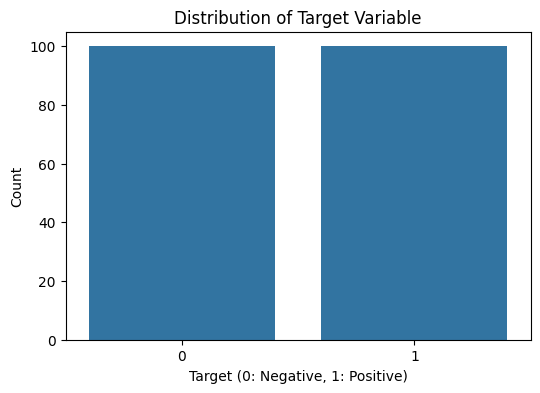

In [533]:
# Distribution of the Target variable
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Target")
plt.title("Distribution of Target Variable")
plt.xlabel("Target (0: Negative, 1: Positive)")
plt.ylabel("Count")
plt.show()

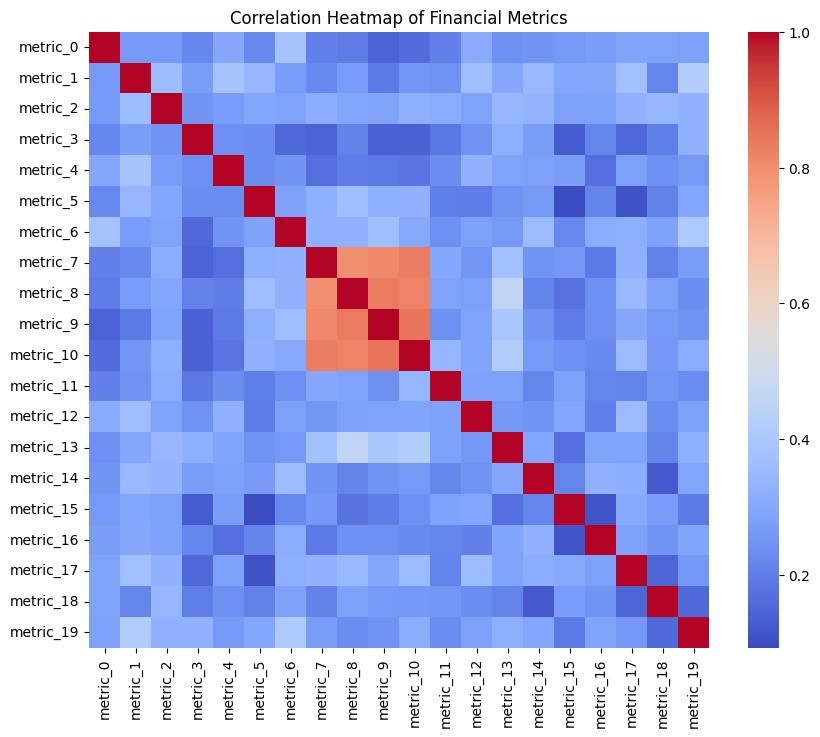

In [534]:
# Correlation Heatmap of the 20 financial metrics
plt.figure(figsize=(10,8))
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Financial Metrics")
plt.show()

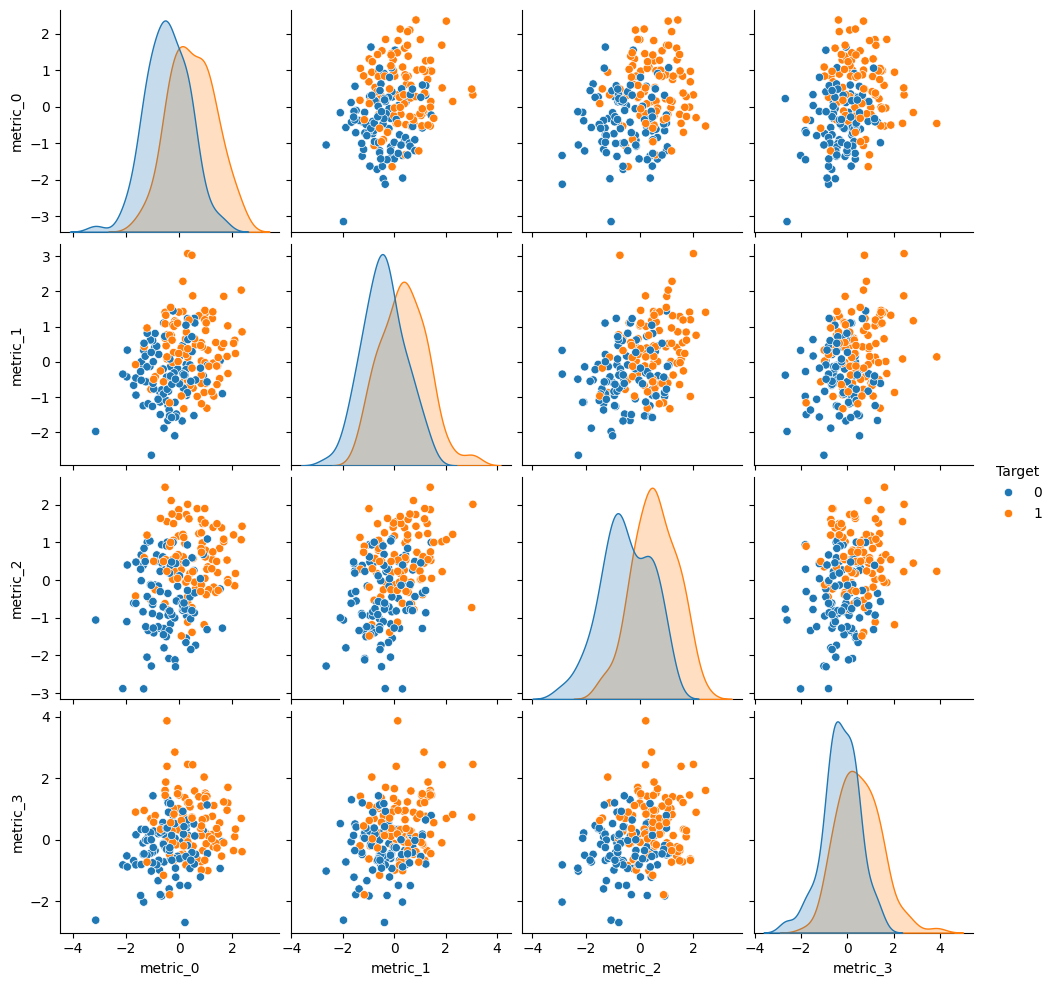

In [535]:
# Pairplot to visualize relationships between a few selected features and the Target variable
selected_features = features[:4] + ["Target"]
sns.pairplot(df[selected_features], hue="Target")
plt.show()

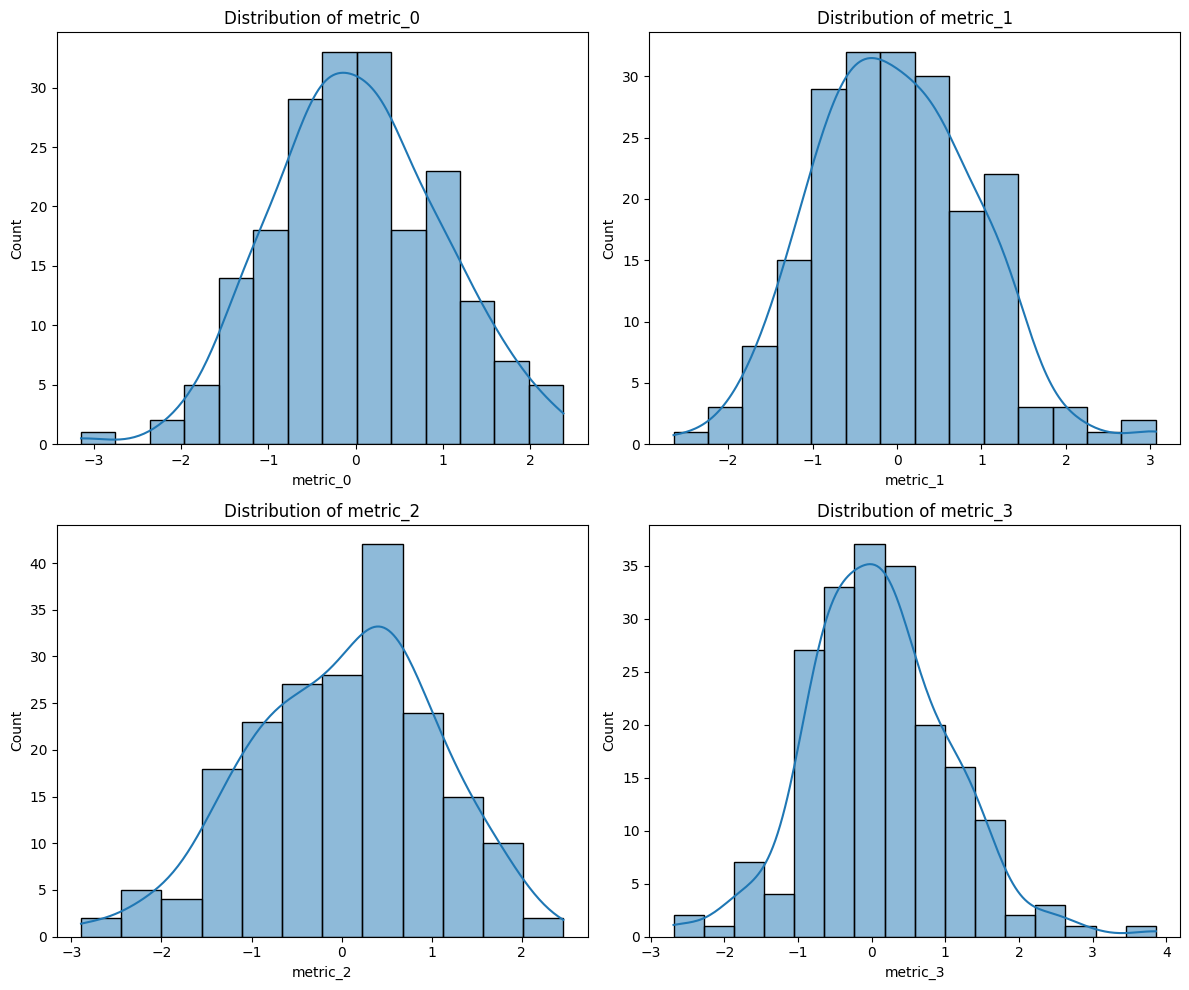

In [536]:
# Distribution plots for a few features
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, feature in zip(axes.flatten(), features[:4]):
    sns.histplot(df[feature], kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

---
#### Model building
---

In [537]:
# Defining the features and target variable
X = df.drop("Target", axis=1)
y = df["Target"]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [538]:
# RandomForestClassifier for the raw features
raw_cls = RandomForestClassifier(random_state=42)
raw_cls.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [539]:
# Predictions and probabilities
y_pred = raw_cls.predict(X_test)
y_proba = raw_cls.predict_proba(X_test)[:, 1]

In [540]:
# Evaluating the model with the 20 features (raw model)
cnf = confusion_matrix(y_test, y_pred)
print('Confusion matrix: ',cnf)
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)
precision = precision_score(y_test, y_pred)
print('Precision: ',precision)
recall = recall_score(y_test, y_pred)
print('Recall: ',recall)
f1 = f1_score(y_test, y_pred)
print('F1-Score: ',f1)
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC score: ',roc_auc)
print(classification_report(y_test, y_pred))
briascore = brier_score_loss(y_test, y_pred)
print('Brier score: ',briascore)


Confusion matrix:  [[13  4]
 [ 3 20]]
Accuracy:  0.825
Precision:  0.8333333333333334
Recall:  0.8695652173913043
F1-Score:  0.851063829787234
ROC score:  0.8171355498721227
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.83      0.87      0.85        23

    accuracy                           0.82        40
   macro avg       0.82      0.82      0.82        40
weighted avg       0.82      0.82      0.82        40

Brier score:  0.175


In [541]:
from sklearn.ensemble import GradientBoostingClassifier

gb_raw = GradientBoostingClassifier(random_state=42)
gb_raw.fit(X_train, y_train)
y_pred_raws = gb_raw.predict(X_test)
y_proba_raws = gb_raw.predict_proba(X_test)[:, 1]

print("Gradient Boosting (Raw Features) Metrics:")
cnf_raw = confusion_matrix(y_test, y_pred_raws)
print("Confusion Matrix:", cnf_raw)
acc_raw = accuracy_score(y_test, y_pred_raws)
print("Accuracy:", acc_raw)
prec_raw = precision_score(y_test, y_pred_raws)
print("Precision:", prec_raw)
rec_raw = recall_score(y_test, y_pred_raws)
print("Recall:", rec_raw)
f1_raws = f1_score(y_test, y_pred_raws)
print("F1-Score:", f1_raws)
roc_raws = roc_auc_score(y_test, y_proba_raws)
print("ROC AUC Score:", roc_raws)
print(classification_report(y_test, y_pred_raws))
brier_raw = brier_score_loss(y_test, y_proba_raws)
print("Brier Score:", brier_raw)


Gradient Boosting (Raw Features) Metrics:
Confusion Matrix: [[13  4]
 [ 2 21]]
Accuracy: 0.85
Precision: 0.84
Recall: 0.9130434782608695
F1-Score: 0.8749999999999999
ROC AUC Score: 0.9130434782608696
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.84      0.91      0.87        23

    accuracy                           0.85        40
   macro avg       0.85      0.84      0.84        40
weighted avg       0.85      0.85      0.85        40

Brier Score: 0.12641003446990934


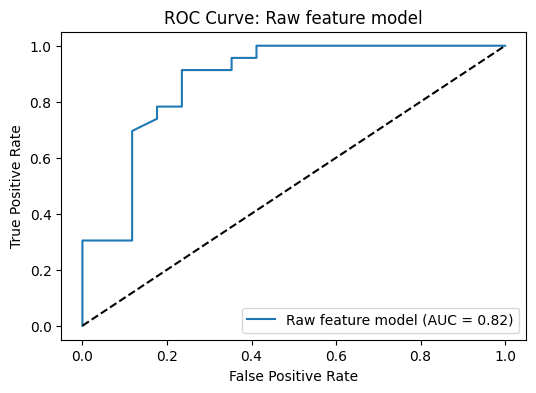

In [542]:
#ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Raw feature model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve: Raw feature model")
plt.legend()
plt.show()

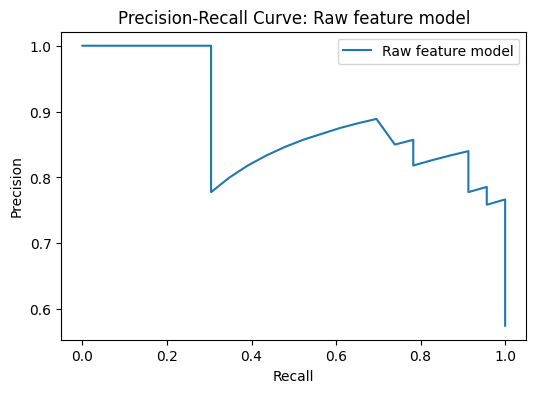

In [543]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label='Raw feature model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f"Precision-Recall Curve: Raw feature model")
plt.legend()
plt.show()

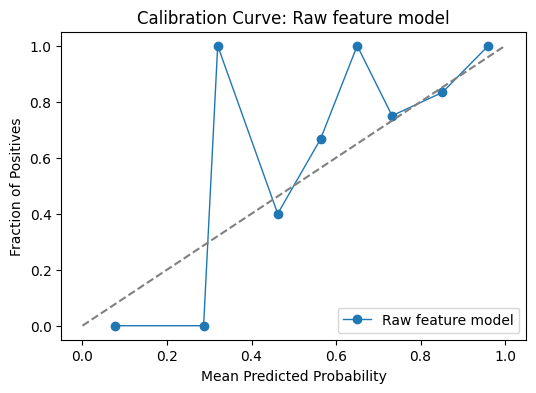

In [544]:
# Probability Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Raw feature model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f"Calibration Curve: Raw feature model")
plt.legend()
plt.show()

---

# Factor-based feature

---

In [545]:
# Reduce 20 features to 5 latent factors
fa = FactorAnalysis(n_components=5, random_state=42)
X_train_factors = fa.fit_transform(X_train)
X_test_factors = fa.transform(X_test)

In [546]:
# RandomForestClassifier for the factor-based features
factor_cls = RandomForestClassifier(random_state=42)
factor_cls.fit(X_train_factors, y_train)

RandomForestClassifier(random_state=42)

In [547]:
# Predictions and probabilities
y_pred_factors = factor_cls.predict(X_test_factors)
y_proba_factors = factor_cls.predict_proba(X_test_factors)[:, 1]

In [548]:
# Evaluating the model with the 20 features (raw model)
cnf = confusion_matrix(y_test, y_pred_factors)
print('Confusion matrix: ',cnf)
acc = accuracy_score(y_test, y_pred_factors)
print('Accuracy: ',acc)
precision = precision_score(y_test, y_pred_factors)
print('Precision: ',precision)
recall = recall_score(y_test, y_pred_factors)
print('Recall: ',recall)
f1 = f1_score(y_test, y_pred_factors)
print('F1-Score: ',f1)
roc_auc = roc_auc_score(y_test, y_pred_factors)
print('ROC score: ',roc_auc)
print(classification_report(y_test, y_pred_factors))
briascore = brier_score_loss(y_test, y_pred_factors)
print('Brier score: ',briascore)

Confusion matrix:  [[12  5]
 [ 4 19]]
Accuracy:  0.775
Precision:  0.7916666666666666
Recall:  0.8260869565217391
F1-Score:  0.8085106382978724
ROC score:  0.7659846547314578
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        17
           1       0.79      0.83      0.81        23

    accuracy                           0.78        40
   macro avg       0.77      0.77      0.77        40
weighted avg       0.77      0.78      0.77        40

Brier score:  0.225


In [549]:
gb_factors = GradientBoostingClassifier(random_state=42)
gb_factors.fit(X_train_factors, y_train)
y_pred_factor = gb_factors.predict(X_test_factors)
y_proba_factor = gb_factors.predict_proba(X_test_factors)[:, 1]

print("\nGradient Boosting (Factor-Based) Metrics:")
cnf_factor = confusion_matrix(y_test, y_pred_factor)
print("Confusion Matrix:", cnf_factor)
acc_factor = accuracy_score(y_test, y_pred_factor)
print("Accuracy:", acc_factor)
prec_factor = precision_score(y_test, y_pred_factor)
print("Precision:", prec_factor)
rec_factor = recall_score(y_test, y_pred_factor)
print("Recall:", rec_factor)
f1_factor = f1_score(y_test, y_pred_factor)
print("F1-Score:", f1_factor)
roc_factor = roc_auc_score(y_test, y_proba_factor)
print("ROC AUC Score:", roc_factor)
print(classification_report(y_test, y_pred_factor))
brier_factor = brier_score_loss(y_test, y_proba_factor)
print("Brier Score:", brier_factor)


Gradient Boosting (Factor-Based) Metrics:
Confusion Matrix: [[12  5]
 [ 5 18]]
Accuracy: 0.75
Precision: 0.782608695652174
Recall: 0.782608695652174
F1-Score: 0.782608695652174
ROC AUC Score: 0.8363171355498722
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.78      0.78      0.78        23

    accuracy                           0.75        40
   macro avg       0.74      0.74      0.74        40
weighted avg       0.75      0.75      0.75        40

Brier Score: 0.20967983660548173


In [550]:
# Factor loadings
factor_loadings = pd.DataFrame(fa.components_.T, index=features, columns=[f"Factor_{i+1}" for i in range(fa.n_components)])
print("Factor Loadings:")
print(factor_loadings)

Factor Loadings:
           Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
metric_0  -0.310920 -0.425009  0.198392 -0.050147 -0.156030
metric_1  -0.358232 -0.504891  0.002220  0.009251  0.178365
metric_2  -0.424289 -0.433754 -0.003334  0.009801 -0.048432
metric_3  -0.224008 -0.429094  0.032865  0.225905  0.188478
metric_4  -0.267995 -0.419059  0.221228 -0.112770  0.045646
metric_5  -0.432765 -0.183163 -0.062375  0.143192  0.044483
metric_6  -0.496961 -0.404163 -0.068193 -0.018728 -0.250361
metric_7  -0.915204  0.123701 -0.009175 -0.098643 -0.053307
metric_8  -0.938723  0.128048  0.153089  0.144986  0.021747
metric_9  -0.960166  0.190060  0.013953 -0.007625 -0.003127
metric_10 -0.965281  0.126398 -0.125517 -0.070673  0.021242
metric_11 -0.369201 -0.299581  0.023187 -0.081446  0.037739
metric_12 -0.445811 -0.404762  0.147774 -0.118398  0.214949
metric_13 -0.543122 -0.267469  0.046959  0.249666  0.009807
metric_14 -0.332434 -0.434999 -0.072995  0.097782 -0.038054
metric_15 -0.288112 -0.

# Latent Factor Interpretation Table

| Latent Factor | Dominant Metrics (Mapped) | Interpretation |
|---------------|---------------------------|----------------|
| **Factor 1**  | F1: Price-to-Earnings Ratio, F2: Price-to-Book Ratio, F3: Dividend Yield, F4: Debt-to-Equity Ratio, F5: Current Ratio, F6: Quick Ratio, F7: Return on Equity (ROE) | **Fundamental Valuation & Liquidity:** Captures intrinsic valuation and liquidity conditions that reflect a firm’s basic financial health. |
| **Factor 2**  | F8: Return on Assets (ROA), F9: Earnings Per Share (EPS), F10: Revenue Growth (YoY), F11: Market Volatility (30-day) | **Operational Performance & Market Risk:** Represents operational effectiveness combined with market risk exposure. |
| **Factor 3**  | F12: Beta (Market Sensitivity), F13: Trading Volume (Average Daily), F14: Price Momentum (1-month), F15: Operating Margin | **Market Sensitivity & Trading Dynamics:** Emphasizes market responsiveness and trading behavior alongside operational margins. |
| **Factor 4**  | F16: Net Profit Margin, F17: Cash Flow-to-Debt Ratio, F18: Interest Coverage Ratio | **Profitability & Capital Structure:** Focuses on profitability, financial stability, and the balance between debt and earnings. |
| **Factor 5**  | F19: Institutional Ownership (%), F20: Short Interest (% of Float) | **Investor Sentiment & Market Perception:** Reflects investor confidence and market expectations as interpreted through ownership and short interest. |

*This table provides a qualitative interpretation of the latent factors revealed by factor analysis, enhancing the financial insights derived from the 20 original metrics.*

In [555]:

factor_scores = fa.transform(df[features])

# Function to compute entropy
def compute_entropy(x, bins=20):
    counts, _ = np.histogram(x, bins=bins, density=True)
    prob = counts / counts.sum()
    prob = prob[prob > 0]
    return -np.sum(prob * np.log(prob))
    
# Compute entropy for each latent factor
entropy_values = {}
for i in range(fa.n_components):
    entropy_values[f"Factor_{i+1}"] = compute_entropy(factor_scores[:, i])
    
print("Entropy values for each Factor:")
print(entropy_values)

Entropy values for each Factor:
{'Factor_1': 2.618137577747368, 'Factor_2': 2.541966833031471, 'Factor_3': 2.588128549050509, 'Factor_4': 2.715168406914961, 'Factor_5': 2.604712970969193}


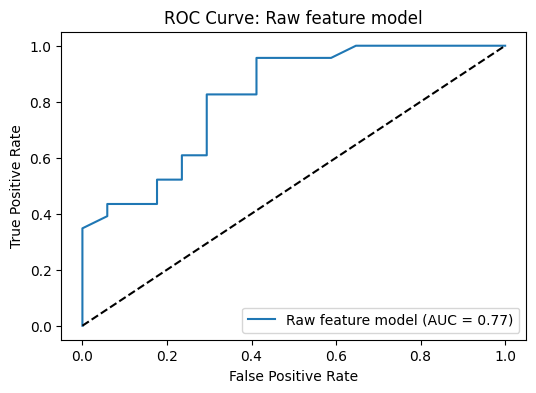

In [551]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_factors)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Raw feature model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve: Raw feature model")
plt.legend()
plt.show()

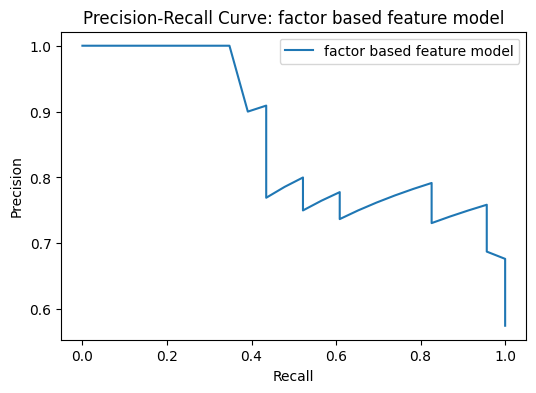

In [552]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_factors)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label='factor based feature model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f"Precision-Recall Curve: factor based feature model")
plt.legend()
plt.show()

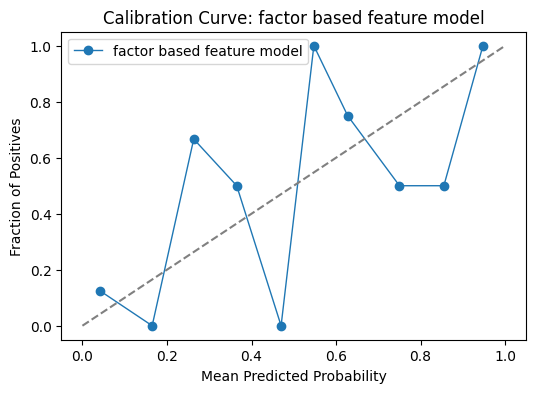

In [553]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_factors, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='factor based feature model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f"Calibration Curve: factor based feature model")
plt.legend()
plt.show()

#### Insights:
- The raw model using all 20 features outperforms the factor-based model in terms of overall accuracy, ROC, and probability calibration.
- Factor Analysis, while useful for reducing multicollinearity and simplifying feature space, may discard some discriminative information required for binary classification.
- In this case, the factor-based model struggles primarily with predicting the negative class (class 0) – evidenced by the lower precision and F1 for class 0.
- These findings indicate that although dimensionality reduction through factor analysis can make models more interpretable, it may come at the cost of predictive performance if the latent factors do not capture all the essential variance present in the original 20 features.
